In [120]:
!pip install utils

In [121]:
!pip install segmentation_models_pytorch

In [122]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from tqdm import tqdm
from utils import *
import segmentation_models_pytorch as smp
from PIL import Image

In [123]:
glob('/kaggle/input/flood-area-segmentation/Image')

['/kaggle/input/flood-area-segmentation/Image']

In [124]:

class Segmentations(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path_jpg = sorted(glob(os.path.join(root, "/kaggle/input/flood-area-segmentation/Image/*")))
        self.im_mask_png = sorted(glob(os.path.join(root, "/kaggle/input/flood-area-segmentation/Mask/*")))

        self.total_ims = len(self.im_path_jpg)
        self.total_gts = len(self.im_mask_png)

        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')

    def __len__(self):
        return len(self.im_path_jpg)

    def __getitem__(self, idx):
        im = np.array(Image.open(self.im_path_jpg[idx]).convert('RGB'))
        gt = np.array(Image.open(self.im_mask_png[idx]))

        if self.transformations is not None:
            transformed = self.transformations(image=im, mask=gt)
            im, gt = transformed['image'], transformed['mask']

        return self.tensorize(im), torch.tensor(gt > 128).long()


def get_transformation(size):
    tfs = A.Compose([A.Resize(size, size)])
    return tfs


tfs = get_transformation(256)
ds = Segmentations(root='data', transformations=tfs)
print(type(ds[0][0]))
print(ds[0][1].shape)

There are 290 images and 290 masks in the dataset
<class 'torch.Tensor'>
torch.Size([256, 256])


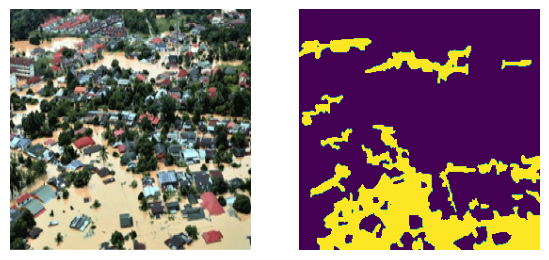

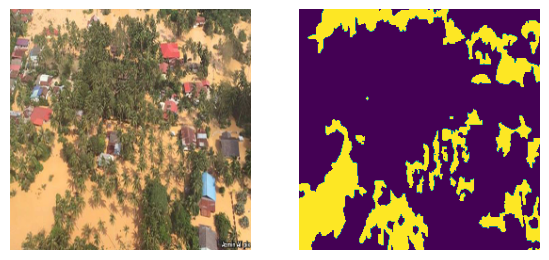

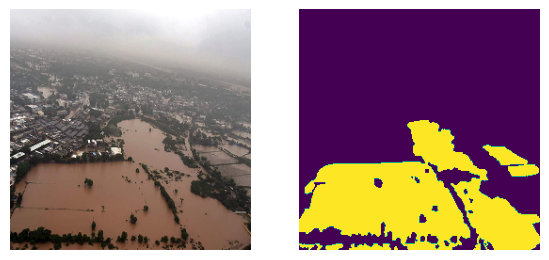

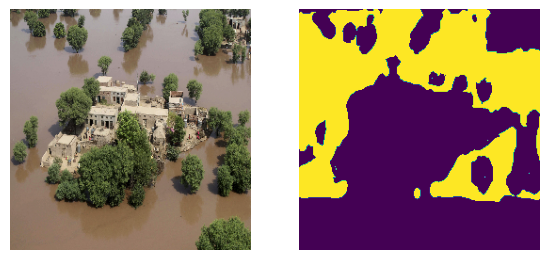

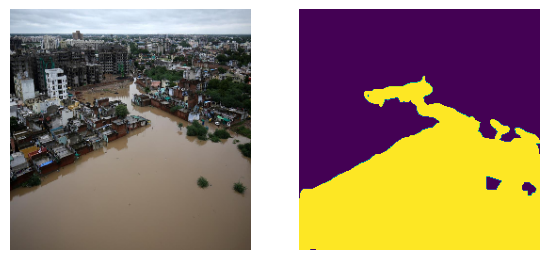

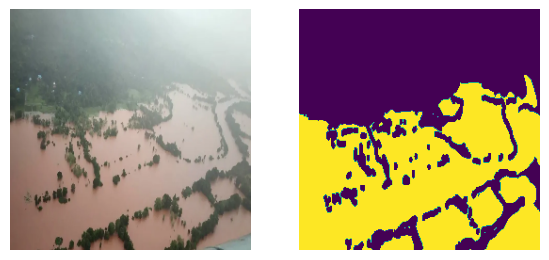

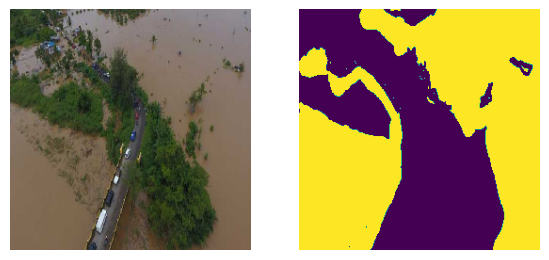

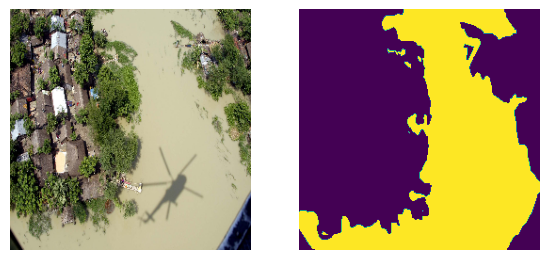

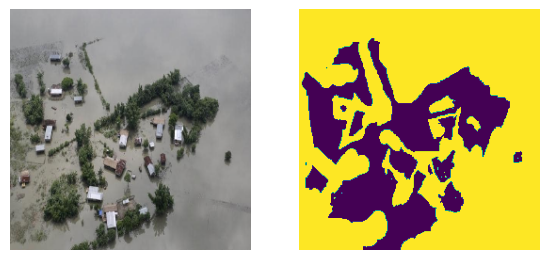

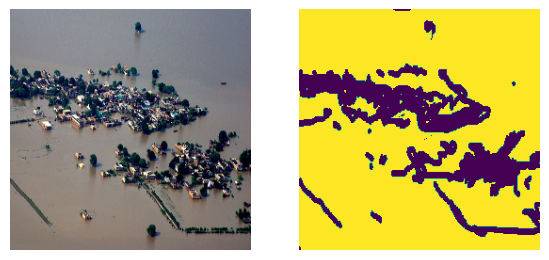

<Figure size 1800x1800 with 0 Axes>

In [125]:
def showing(ds, img_num=10, row=2):
    for idx, (im, gt) in enumerate(ds):
        count = 1
        plt.figure(figsize=(18,18))
        if idx == 10: break
        im = (im * 255).detach().cpu().permute(1,2,0).numpy().astype('uint8')# integer 8
        gt = (gt * 255).detach().cpu().numpy().astype('uint8')
        plt.subplot(row, img_num // row, count)
        plt.imshow(im)
        plt.axis('off')
        count += 1
        plt.subplot(row, img_num // row, count)
        plt.imshow(gt)
        plt.axis('off')
        count += 1
        plt.show()
        
showing(ds, 10, 2)    

In [126]:
def get_dl(root, transformations, bs, split = [0.7, 0.15, 0.15]):
    
    assert sum(split) == 1
    # Get dataset
    ds = Segmentations(root = root, transformations = tfs)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    
    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = bs, shuffle = False)
    
    return tr_dl, val_dl, test_dl 
    
tr_dl, val_dl, test_dl = get_dl(root = "data", bs = 64, transformations = tfs) 


There are 290 images and 290 masks in the dataset
There are 203 images in the trainset
There are 43 images in the validation set
There are 44 images in the test set


In [127]:
class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, n_cls = 2):
        
        
        self.pred_ = pred # to compute loss value
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1)), gt 
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim = 1), gt 
        self.loss_fn, self.eps, self.n_cls = loss_fn, eps, n_cls
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) # (3, 224, 224) -> (3 * 224 * 224)

    def PA(self):
        
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.gt).int()
            
        return float(match.sum()) / float(match.numel()) # numel() is a number of elements in match
    
    def mIoU(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            
            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt   == c
                
                # If there is no background class
                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                
                else:
                    
                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    
                    iou = (intersection) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, self.gt)
    



In [128]:
model = smp.Unet(encoder_name = 'resnet18',
               encoder_weights = 'imagenet',
               in_channels = 3,
               classes = 2,
               encoder_depth = 5,
               decoder_channels = [256,128,64,32,16])

In [129]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

In [130]:
def train(model, tr_dl, val_dl, loss_fn, opt, epochs, device, patience):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss = torch.tensor(float("inf"))
    not_improved = 0
    #os.makedirs("saved_models", exist_ok = True)
    
    model.to(device)
    for epoch in range(1, epochs + 1):  
        
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        
        print(f"{epoch}-epoch train is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            
            pred = model(im)
            
            met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)
            
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_
            
            loss_.backward() 
            opt.step() 
            opt.zero_grad()
            
        print(f"{epoch}-epoch train is finished!")
        print(f"{epoch}-epoch validation is started...")
        
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
            
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)

                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                val_loss_ += met.loss().item()
            
        print(f"{epoch}-epoch validation is finished!")
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} Train Process Results: \n")
        print(f"Train loss          -> {tr_loss_:.3f}")
        print(f"Train PA            -> {tr_pa_:.3f}")
        print(f"Train mIoU          -> {tr_iou_:.3f}")
        print(f"Validation loss     -> {val_loss_:.3f}")
        print(f"Validation PA       -> {val_pa_:.3f}")
        print(f"Validation mIoU     -> {val_iou_:.3f}")
        
        tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_)
        val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_)
        
        if best_loss < val_loss_:
            print(f"Loss value did not decrease")
            not_improved += 1
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
        
        else:
            print(f"Loss decreased from {best_loss} to {val_loss_}")
            best_loss = val_loss_
                        
    return{"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
              "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou} 


In [131]:
his = train(model = model, tr_dl = tr_dl,
            val_dl = val_dl, loss_fn = loss_fn,
            opt = opt, epochs = 10, device = "cuda",
             patience = 4)

1-epoch train is started...


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


1-epoch train is finished!
1-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


1-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 Train Process Results: 

Train loss          -> 0.680
Train PA            -> 0.648
Train mIoU          -> 0.433
Validation loss     -> 0.858
Validation PA       -> 0.594
Validation mIoU     -> 0.316
Loss decreased from inf to 0.8576621413230896
2-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


2-epoch train is finished!
2-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


2-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 Train Process Results: 

Train loss          -> 0.474
Train PA            -> 0.794
Train mIoU          -> 0.642
Validation loss     -> 0.575
Validation PA       -> 0.728
Validation mIoU     -> 0.544
Loss decreased from 0.8576621413230896 to 0.5751537680625916
3-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


3-epoch train is finished!
3-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


3-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 Train Process Results: 

Train loss          -> 0.397
Train PA            -> 0.851
Train mIoU          -> 0.731
Validation loss     -> 0.511
Validation PA       -> 0.778
Validation mIoU     -> 0.631
Loss decreased from 0.5751537680625916 to 0.5105078816413879
4-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


4-epoch train is finished!
4-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


4-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 Train Process Results: 

Train loss          -> 0.357
Train PA            -> 0.875
Train mIoU          -> 0.771
Validation loss     -> 0.487
Validation PA       -> 0.808
Validation mIoU     -> 0.671
Loss decreased from 0.5105078816413879 to 0.4870295822620392
5-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


5-epoch train is finished!
5-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


5-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 Train Process Results: 

Train loss          -> 0.329
Train PA            -> 0.881
Train mIoU          -> 0.780
Validation loss     -> 0.440
Validation PA       -> 0.832
Validation mIoU     -> 0.704
Loss decreased from 0.4870295822620392 to 0.439850389957428
6-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


6-epoch train is finished!
6-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


6-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 Train Process Results: 

Train loss          -> 0.300
Train PA            -> 0.892
Train mIoU          -> 0.800
Validation loss     -> 0.400
Validation PA       -> 0.847
Validation mIoU     -> 0.729
Loss decreased from 0.439850389957428 to 0.3999056816101074
7-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


7-epoch train is finished!
7-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


7-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 Train Process Results: 

Train loss          -> 0.256
Train PA            -> 0.911
Train mIoU          -> 0.830
Validation loss     -> 0.339
Validation PA       -> 0.869
Validation mIoU     -> 0.762
Loss decreased from 0.3999056816101074 to 0.33860471844673157
8-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


8-epoch train is finished!
8-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


8-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 Train Process Results: 

Train loss          -> 0.264
Train PA            -> 0.905
Train mIoU          -> 0.821
Validation loss     -> 0.307
Validation PA       -> 0.880
Validation mIoU     -> 0.781
Loss decreased from 0.33860471844673157 to 0.3069249391555786
9-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


9-epoch train is finished!
9-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


9-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 Train Process Results: 

Train loss          -> 0.230
Train PA            -> 0.918
Train mIoU          -> 0.844
Validation loss     -> 0.300
Validation PA       -> 0.882
Validation mIoU     -> 0.784
Loss decreased from 0.3069249391555786 to 0.2995302081108093
10-epoch train is started...


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


10-epoch train is finished!
10-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

10-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 Train Process Results: 

Train loss          -> 0.216
Train PA            -> 0.923
Train mIoU          -> 0.852
Validation loss     -> 0.275
Validation PA       -> 0.893
Validation mIoU     -> 0.802
Loss decreased from 0.2995302081108093 to 0.27521878480911255


In [132]:

def plot_results(his):
    tr_loss = [loss.item() for loss in his['tr_loss']]
    tr_pa = his["tr_pa"]
    tr_iou = his["tr_iou"]
    val_loss = his["val_loss"]
    val_pa = his["val_pa"]
    val_iou = his["val_iou"]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(tr_loss, label="Train_Loss")
    plt.plot(val_loss, label="Validation_Loss")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(tr_pa, label="Train_PA")
    plt.plot(val_pa, label="Validation_PA")
    plt.title("Pixel Accuracy (PA)")
    plt.ylabel("PA")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(tr_iou, label="Train_IoU")
    plt.plot(val_iou, label="Validation_IoU")
    plt.title("Intersection over Union (IoU)")
    plt.ylabel("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()

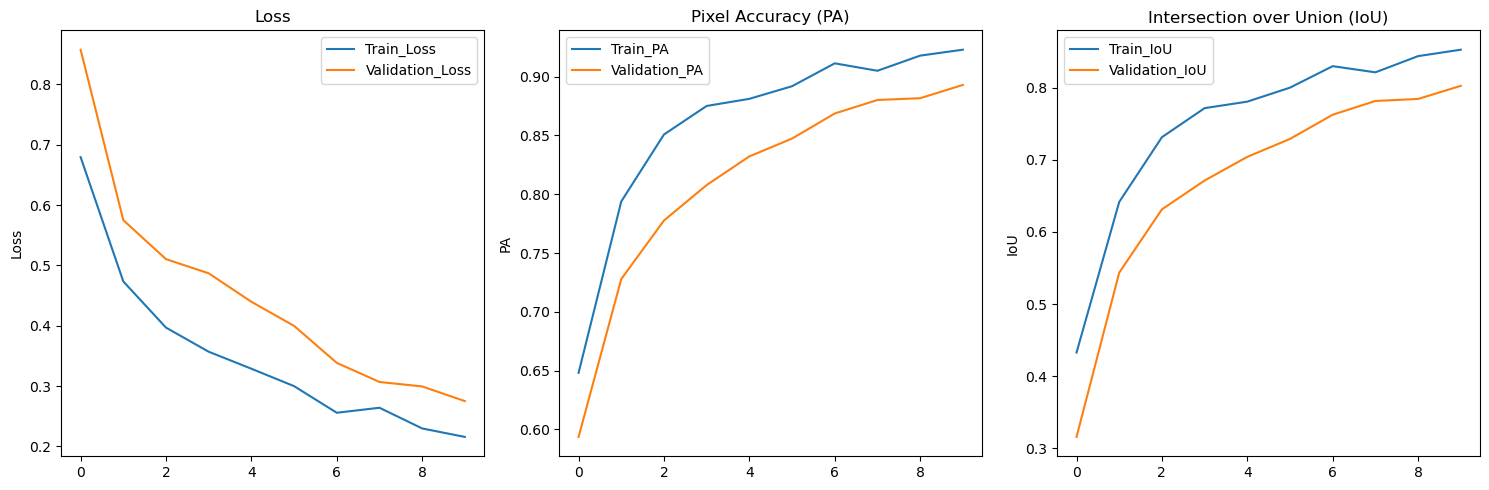

In [133]:
plot_results(his)

In [134]:
device = 'cuda'

In [135]:
ims, gts = next(iter(test_dl))
model.eval()

preds, images, lbls = [], [], []
for im, gt in zip(ims, gts):
    im, gt = im.to(device), gt.to(device)
    pred = model(im.unsqueeze(0)) 
    images.append(im)
    preds.append(pred)
    lbls.append(gt)
    
print(len(preds))

44


In [136]:
def tensor_2_im(t):
    return (t * 255).cpu().permute(1, 2, 0).numpy().astype(np.uint8)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

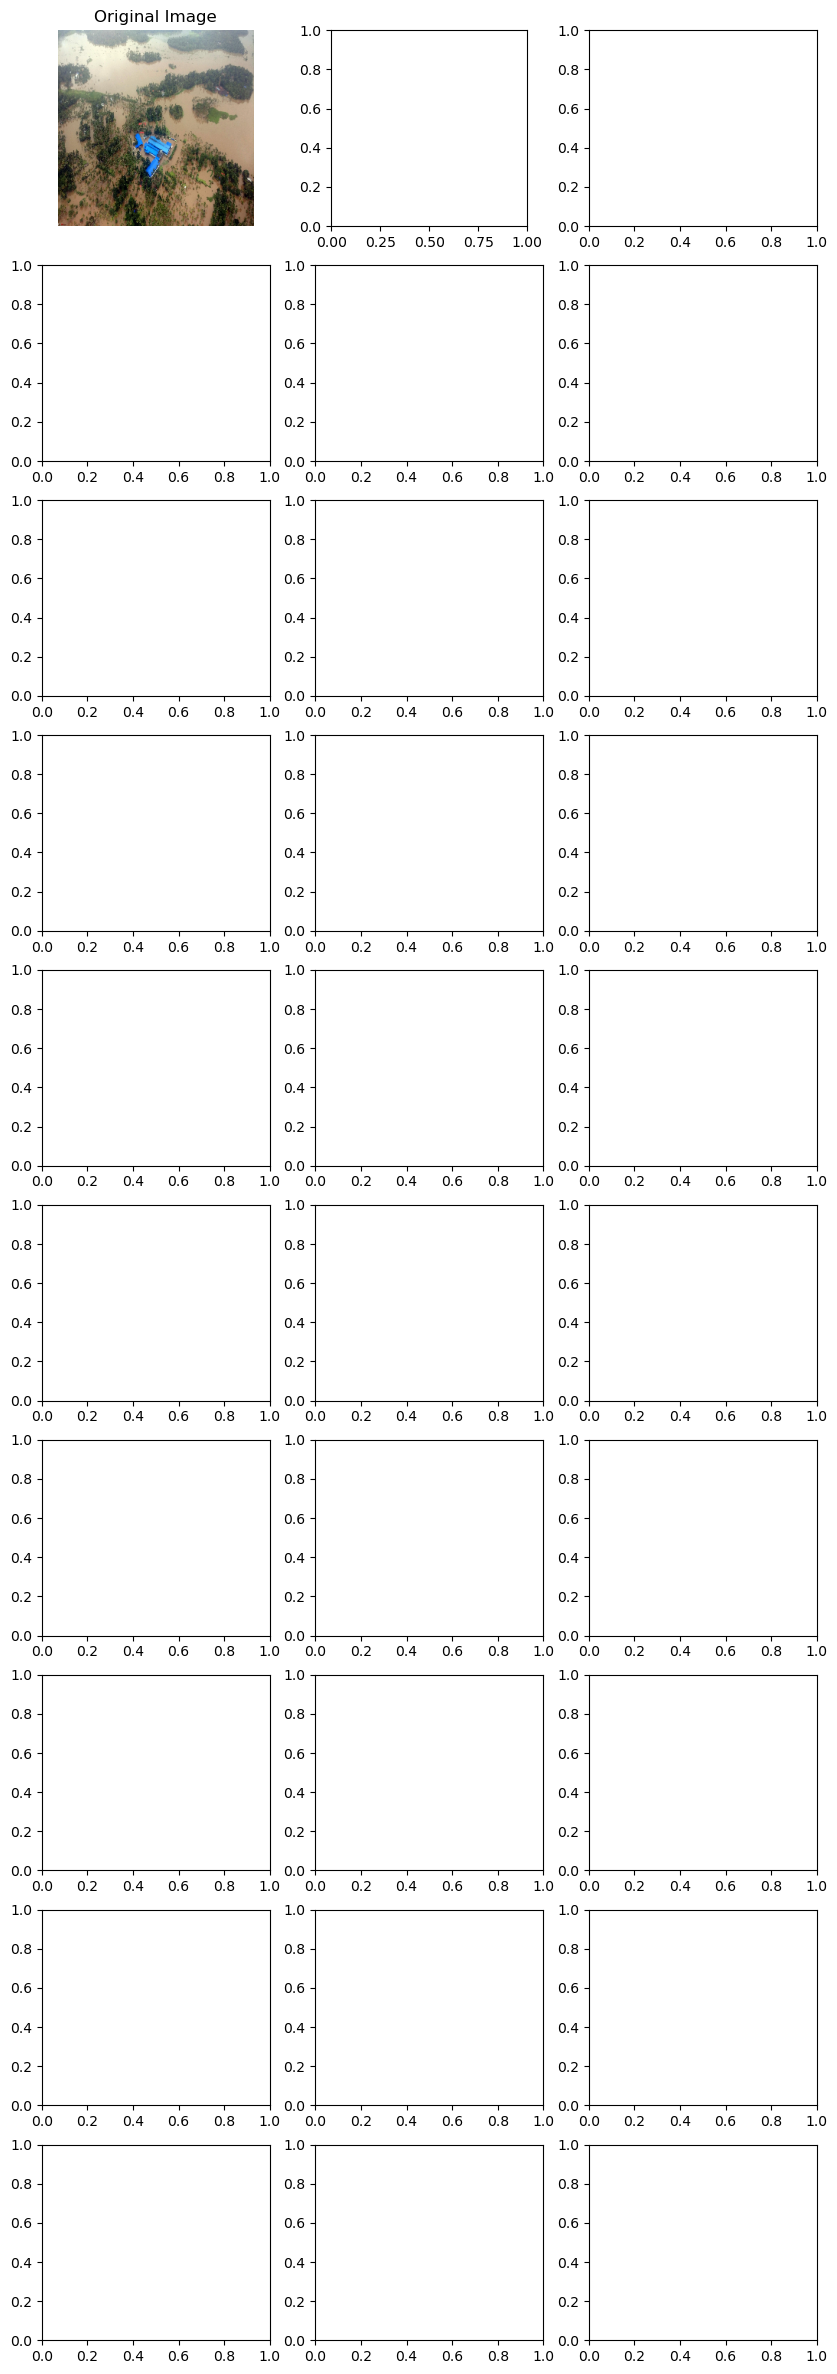

In [138]:
import random

indices = random.sample(range(len(images)), 10)


fig, axs = plt.subplots(10, 3, figsize=(10, 30))


for i, idx in enumerate(indices):
    im = images[idx]
    pred = preds[idx]
    gt = lbls[idx]

    # Plot the original image
    axs[i, 0].imshow(tensor_2_im(im))
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    # Plot the predicted label
    axs[i, 1].imshow(pred, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Predicted Label')

    # Plot the ground truth label
    axs[i, 2].imshow(gt, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Ground Truth Label')

plt.tight_layout()
plt.show()